In [1]:
import numpy as np
import pandas as pd

## Process missing data
### Set parameter 'type_of_processed_missing' to a valid value ('mean','median','zero_padding')

In [107]:
from processing_missing_data import ProcessingMissingData
import pickle
## Processing the dataset with the class ProcessingMissingData

## Load train data
## Process the data with the sampler and segmenter
with open('Data\\train_inputs.pkl', 'rb') as handle:
    list_of_trains = pickle.load(handle)

processing_missing_data_obj = ProcessingMissingData()
## type accepts - 'mean', 'median', 'zero_padding'
type_of_processed_missing = 'zero_padding'
list_of_missing_vals_processed_trains_concat = processing_missing_data_obj.get_processed_dataset_as_list_of_vectors(list_of_data=list_of_trains, type=type_of_processed_missing)

list_of_missing_preprocessed_trains = processing_missing_data_obj.get_processed_dataset(list_of_data=list_of_trains, type=type_of_processed_missing)

In [108]:
## Concatenating two numpy arrays demo (needed for Kaan's method)
#np.concatenate((list_of_missing_vals_processed_trains_concat[0], np.array([1,2,3])))

## Process data to be ready to segment/sample
### Uncomment/Comment the correct 'curr_list_of_trains' depending if you want the raw data or with filled missing values

In [109]:
from person_processing import PersonProcessing
import pickle

## Process the data with the sampler and segmenter
with open('Data\\train_inputs.pkl', 'rb') as handle:
    list_of_trains = pickle.load(handle)


# RAW TRAINS or WITHOUT MISSING DATA TRAINS
curr_list_of_trains = list_of_trains # RAW
#curr_list_of_trains = list_of_missing_preprocessed_trains # Filled missing values data

# parameter k
param_k = 5   
# dict with key k number of samples taken and value list of vectors for that particular k
# dict with key k number of segmentations taken and value list of vectors for that particular k
dict_of_k_samples_features = dict()
dict_of_k_segmentations_features = dict()
for train_sample in curr_list_of_trains:
    for curr_k in range(2,param_k+1):
        person_processing_obj = PersonProcessing(train_sample)
        results_sampling = person_processing_obj.get_sampling(k=curr_k)
        results_segmentation = person_processing_obj.get_segmentation(k=curr_k)

        if curr_k in dict_of_k_samples_features:
            dict_of_k_samples_features[curr_k].append(results_sampling)
        else:
            dict_of_k_samples_features[curr_k] = list()
            dict_of_k_samples_features[curr_k].append(results_sampling)

        if curr_k in dict_of_k_segmentations_features:
            dict_of_k_segmentations_features[curr_k].append(results_segmentation)
        else:
            dict_of_k_segmentations_features[curr_k] = list()
            dict_of_k_segmentations_features[curr_k].append(results_segmentation)

## Get Peak Detection

In [110]:
from person_processing import PersonProcessing
import pickle

## Process the data with the sampler and segmenter
with open('Data\\train_inputs.pkl', 'rb') as handle:
    list_of_trains = pickle.load(handle)

#curr_list_of_trains = list_of_missing_preprocessed_trains # Filled missing values data

list_of_peaks_features = list()
for train_sample in curr_list_of_trains:
    person_processing_obj = PersonProcessing(train_sample)
    results_peaks = person_processing_obj.get_peaks()
    ## Append to list of peaks features
    list_of_peaks_features.append(results_peaks)

In [111]:
len(list_of_peaks_features[0])

240

## Process the labels

In [112]:
## Process the labels
with open('Data\\train_outputs.pkl', 'rb') as handle:
    list_of_train_labels_raw = pickle.load(handle)

In [113]:
list_of_train_labels = list()
for item in list_of_train_labels_raw:
    label_idx = (item[0] == 1).nonzero()[0][0]
    list_of_train_labels.append(label_idx)

## Neural Network Architecture

In [3]:
## Neural Network Architecture
from torch import nn
import torch 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class JapaneseVowelsNN(nn.Module):
    def __init__(self, feature_dim, num_classes, dropout_rate):
        super(JapaneseVowelsNN, self).__init__()
        
        self.input_layer = nn.Linear(feature_dim, feature_dim*2)
        self.hidden_layer = nn.Linear(feature_dim*2, feature_dim)
        self.hidden_layer2 = nn.Linear(feature_dim, int(feature_dim/2))
        self.output_layer = nn.Linear(int(feature_dim/2), num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm1 = nn.BatchNorm1d(feature_dim*2)
        self.batchnorm2 = nn.BatchNorm1d(feature_dim)
        self.batchnorm3 = nn.BatchNorm1d(int(feature_dim/2))
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.hidden_layer(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.hidden_layer2(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output_layer(x)
        
        return x

## Methods - make sure to compile before executing a method anywhere in the code

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from passing_through_regions import FeatureSelection

## Function for creating the data loaders and making train validate sets
def prepare_dataset(type='segmentation', k=2):
    if type=='segmentation':
        dataset = list(zip(torch.from_numpy(np.array(dict_of_k_segmentations_features[k])), 
        torch.from_numpy(np.array(list_of_train_labels))))

    elif type=='sampling':
        dataset = list(zip(torch.from_numpy(np.array(dict_of_k_samples_features[k])), 
        torch.from_numpy(np.array(list_of_train_labels))))

    elif type=='processed_missing':
        dataset = list(zip(torch.from_numpy(np.array(list_of_missing_vals_processed_trains_concat)), 
        torch.from_numpy(np.array(list_of_train_labels))))

    elif type=='peak_detection':
        dataset = list(zip(torch.from_numpy(np.array(list_of_peaks_features)), 
        torch.from_numpy(np.array(list_of_train_labels))))

    return dataset

def prepare_pca_train_val_data(train_data, val_data, train_labels_pca, val_labels_pca, n_components=60):
    features = FeatureSelection(train_data, n_pc=n_components)
    transformed_train_data = features.get_training_features()
    transformed_val_data = features.pca_transform_data(val_data)

    # concat with labels
    train_data = list(zip(torch.from_numpy(np.array(transformed_train_data)), 
        torch.from_numpy(np.array(train_labels_pca))))
    val_data = list(zip(torch.from_numpy(np.array(transformed_val_data)), 
        torch.from_numpy(np.array(val_labels_pca))))

    return train_data, val_data

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    return acc * 100

def create_cross_validator(n_splits=10):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    return cv

def create_data_loaders(train_data, val_data=None, BATCH_SIZE=27):
    if val_data is not None:
        train_data_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
        val_data_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)
        return train_data_loader, val_data_loader
    else:
        train_data_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
        return train_data_loader

def save_transformed_pca_data_cv(transformed_train_data_pca, transformed_val_data_pca, k_fold_num):
    if not os.path.isdir('{}\\Data\\{}\\'.format(os.getcwd(),'passing_regions_PCA')):
        os.makedirs('{}\\Data\\{}\\'.format(os.getcwd(),'passing_regions_PCA'))

    with open('{}\\Data\\{}\\transformed_train_data_pca_cv_{}.pkl'.
        format(os.getcwd(),'passing_regions_PCA',k_fold_num), 'wb')  as handle:
                pickle.dump(transformed_train_data_pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('{}\\Data\\{}\\transformed_val_data_pca_cv_{}.pkl'.
        format(os.getcwd(),'passing_regions_PCA',k_fold_num), 'wb')  as handle:
                pickle.dump(transformed_val_data_pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_transformed_pca_data_cv(k_fold_num):
    try:
        with open('{}\\Data\\{}\\transformed_train_data_pca_cv_{}.pkl'.
            format(os.getcwd(),'passing_regions_PCA',k_fold_num), 'rb') as handle:
                transformed_train_data_pca = pickle.load(handle)

        with open('{}\\Data\\{}\\transformed_val_data_pca_cv_{}.pkl'.
            format(os.getcwd(),'passing_regions_PCA',k_fold_num), 'rb') as handle:
                transformed_val_data_pca = pickle.load(handle)
        
        return transformed_train_data_pca, transformed_val_data_pca
    except:
        return None, None

## Parameter settings
### Set 'TYPE_OF_FEATURES' depending if you want to make experiments for processed_missing, segmentation or sampling
### If you want to make experiment with segmentation + processed_missing (for example segment mean but from data filled with zero padding), make sure that you have set 'curr_list_of_trains' in section 'Process data to be ready to segment\sampling' in the beggining of the notebook to take the filled missing values.

In [116]:
## Parameters
EPOCHS = 200
BATCH_SIZE = 26
LEARNING_RATE = 0.001
NUM_CLASSES = 9
K_FOLD_SPLITS = 27

optimizer_name = 'Adam'
## For automating experiments with different dropout
## Here we are testing from 0 to 0.8
range_of_dropout = [p/10 for p in range(6, 9)]

# Possible types: "segmentation", "sampling", "processed_missing", "passing_regions_PCA"
## Super important to be set correctly as it is used for saving the experiment in the correct dir

###########
TYPE_OF_FEATURES = "segmentation"
###########


if TYPE_OF_FEATURES == "processed_missing":
    ## So we can get the directory 'processed_missing\\mean\\...'
    ## OR 'processed_missing\\median\\...' OR 'processed_missing\\zero_padding\\...'
    ## Basically the type of processed missing
    sub_folder = type_of_processed_missing
    ## Set to zero if type="processed_missing"
    K = 0
    LOOP_START_AT = 0
elif TYPE_OF_FEATURES == 'segmentation':
    # if TYPE_OF_FEATURES == segmentation, we want to have the structure 'segmentation\\zero_padding\\...'
    ## OR 'segmentation\\mean\\...' and so on. 
    ## Basically the type of segmentation

    # In the case where we have segmentation without filling missing values
    if curr_list_of_trains[0].shape[0] < 26:
        sub_folder = 'no_filling_missing'
    else:
        sub_folder = type_of_processed_missing
    K = param_k
    LOOP_START_AT = 5
elif TYPE_OF_FEATURES == 'passing_regions_PCA':
    K = 0
    LOOP_START_AT = 0
    N_COMP = 60
    sub_folder = 'n_comp_{}'.format(N_COMP)

elif TYPE_OF_FEATURES == 'peak_detection':
    sub_folder = type_of_processed_missing
    K = 0
    LOOP_START_AT = 0

## Training. It consists of nested loops, their structure is as follows: <br>
### 1. Loop for dropout rate
###  &emsp;  2. Loop for k-segments (right now k=5 and the loop is static as we don't want other values for k right now)
###    &emsp; &emsp;   3. Loop for 27-fold cross validation
###     &emsp; &emsp; &emsp;     4. Loop for epochs
## After Loop 3 has completed, the following happens:
### 1. Result folder structure is created if it doesn't exist
### 2. Results are saved for the current dropout rate as pickle so they can be analyzed later

In [117]:
from torch import optim
import torch
import numpy as np 
from datetime import datetime
import os
from operator import itemgetter 

## Move model to cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dict_of_k_results = dict()

# Initialize cross valudator
cross_validator = create_cross_validator(n_splits=K_FOLD_SPLITS)
for curr_dropout in range_of_dropout:
    dropout_rate = curr_dropout
    for k in range(LOOP_START_AT,K+1):

            # If we can the process the data at once.
            # Valid for all methods except PCA
            if TYPE_OF_FEATURES != 'passing_regions_PCA':
                # Prepare data
                prepared_data = prepare_dataset(type=TYPE_OF_FEATURES, k=k)
            else:
                prepared_data = list_of_trains

            k_fold_num = 0
            for train_idx, val_idx in cross_validator.split(prepared_data):
                start_time_current_k_fold = datetime.now()
                k_fold_num += 1

                if TYPE_OF_FEATURES != 'passing_regions_PCA':
                    # Create data loaders for train/val for the current cross validation
                    train_loader, val_loader = create_data_loaders(
                        train_data=itemgetter(*train_idx)(prepared_data),
                        val_data=itemgetter(*val_idx)(prepared_data))
                else:
                    transformed_train_data_pca, transformed_val_data_pca = read_transformed_pca_data_cv(k_fold_num=k_fold_num)
                    ## If we don't have the current transformed data saved, we compute it
                    if transformed_train_data_pca is None and transformed_val_data_pca is None:

                        # 'list_of_trains' is the original training data without anything made to it
                        # Separate data depending on the indexes from the current cross validation
                        train_data_pca = itemgetter(*train_idx)(list_of_trains)
                        val_data_pca = itemgetter(*val_idx)(list_of_trains)
                        train_labels_pca = itemgetter(*train_idx)(list_of_train_labels)
                        val_labels_pca = itemgetter(*val_idx)(list_of_train_labels)
                        # Fit transform the training and just transform the validation
                        transformed_train_data_pca, transformed_val_data_pca = \
                        prepare_pca_train_val_data(train_data_pca, val_data_pca, train_labels_pca, val_labels_pca, N_COMP)
                        ## Save the transformed data so it can be used the next time this cross validation is used
                        save_transformed_pca_data_cv(transformed_train_data_pca, transformed_val_data_pca, k_fold_num)

                    # Create data loaders for train-val for the current cross validation
                    train_loader, val_loader = \
                    create_data_loaders(train_data=transformed_train_data_pca, val_data=transformed_val_data_pca)

                    
                # get feature dimensionality to set in the network
                feature_dim = next(iter(train_loader))[0].shape[1]
                print(feature_dim)
                ## Initialize model
                model = JapaneseVowelsNN(feature_dim=feature_dim, num_classes=NUM_CLASSES,dropout_rate=dropout_rate)
                model = model.double()
                model.to(device)

                criterion = nn.CrossEntropyLoss()

                if optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
                elif optimizer_name == 'RMSProp':
                    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
                elif optimizer_name == 'Adagrad':
                    optimizer = optim.Adagrad(model.parameters(), lr=LEARNING_RATE)

                with torch.cuda.device(0):
                    for epoch in range(1, EPOCHS+1):
                        # TRAINING
                        train_epoch_loss = 0
                        train_epoch_acc = 0
                        model.train()
                        for X_train_batch, y_train_batch in train_loader:
                            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
                            optimizer.zero_grad()
                            
                            y_train_pred = model(X_train_batch)
                            
                            train_loss = criterion(y_train_pred, y_train_batch)
                            train_acc = multi_acc(y_train_pred, y_train_batch)
                            
                            train_loss.backward()
                            optimizer.step()
                            
                            train_epoch_loss += train_loss.item()
                            train_epoch_acc += train_acc.item()
                            
                            
                        # VALIDATION    
                        with torch.no_grad():
                            
                            val_epoch_loss = 0
                            val_epoch_acc = 0
                            
                            model.eval()
                            for X_val_batch, y_val_batch in val_loader:
                                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                                
                                y_val_pred = model(X_val_batch)
                                            
                                val_loss = criterion(y_val_pred, y_val_batch)
                                val_acc = multi_acc(y_val_pred, y_val_batch)
                                
                                val_epoch_loss += val_loss.item()
                                val_epoch_acc += val_acc.item()
                        
                        if epoch % 10 == 0:
                            print("Epoch: {} | Train Loss: {} |  Val Loss: {} | Train acc: {} | Val acc: {}".format(epoch,                                                  round(train_epoch_loss/len(train_loader),3), round(val_epoch_loss/len(val_loader),3), round                                                     (train_epoch_acc/len(train_loader),3), round(val_epoch_acc/len(val_loader),3)))
                            #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
                            #print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
                        if epoch == EPOCHS:
                            print('--------k param: {} k-fold num: {} completed!-----------'.format(k, k_fold_num))
                
                ## Check if key exists and create it if it doesnt and saves the results for the current k-fold
                if k not in dict_of_k_results:
                    dict_of_k_results[k] = {'train_acc':[], 'train_loss':[], 'val_acc':[],'val_loss':[],                                                                'type':TYPE_OF_FEATURES, 'convergence_time':[]}

                end_time_current_k_fold = datetime.now()
                dict_of_k_results[k]['train_acc'].append(train_epoch_acc/len(train_loader))
                dict_of_k_results[k]['train_loss'].append(train_epoch_loss/len(train_loader))
                dict_of_k_results[k]['val_acc'].append(val_epoch_acc/len(val_loader))
                dict_of_k_results[k]['val_loss'].append(val_epoch_loss/len(val_loader))
                dict_of_k_results[k]['convergence_time'].append(end_time_current_k_fold-start_time_current_k_fold)
            
            # Check if folder structure is created, if not - create it
            if not os.path.isdir('{}\\Results\\{}\\{}\\'.format(os.getcwd(),TYPE_OF_FEATURES, sub_folder)):
                os.makedirs('{}\\Results\\{}\\{}\\'.format(os.getcwd(),TYPE_OF_FEATURES, sub_folder))
            # Save results as pickles
            with open('{}\\Results\\{}\\{}\\dict_of_k_results_cv{}_dropout-{}_3-layered_{}_epochs_{}_lr_{}.pkl'.
                format(os.getcwd(),TYPE_OF_FEATURES,sub_folder,K_FOLD_SPLITS,dropout_rate,optimizer_name,EPOCHS,LEARNING_RATE), 'wb')                   as handle:
                    pickle.dump(dict_of_k_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

: 20.065 | Val acc: 30.0
Epoch: 150 | Train Loss: 1.961 |  Val Loss: 1.879 | Train acc: 20.436 | Val acc: 20.0
Epoch: 160 | Train Loss: 1.948 |  Val Loss: 1.883 | Train acc: 24.88 | Val acc: 0.0
Epoch: 170 | Train Loss: 1.87 |  Val Loss: 1.873 | Train acc: 24.946 | Val acc: 30.0
Epoch: 180 | Train Loss: 1.896 |  Val Loss: 1.897 | Train acc: 26.296 | Val acc: 30.0
Epoch: 190 | Train Loss: 1.893 |  Val Loss: 1.826 | Train acc: 23.028 | Val acc: 20.0
Epoch: 200 | Train Loss: 1.895 |  Val Loss: 1.849 | Train acc: 27.102 | Val acc: 20.0
--------k param: 5 k-fold num: 16 completed!-----------
60
Epoch: 10 | Train Loss: 2.31 |  Val Loss: 2.163 | Train acc: 15.752 | Val acc: 0.0
Epoch: 20 | Train Loss: 2.217 |  Val Loss: 2.006 | Train acc: 15.969 | Val acc: 20.0
Epoch: 30 | Train Loss: 2.125 |  Val Loss: 1.947 | Train acc: 21.002 | Val acc: 10.0
Epoch: 40 | Train Loss: 2.189 |  Val Loss: 1.866 | Train acc: 11.83 | Val acc: 50.0
Epoch: 50 | Train Loss: 2.062 |  Val Loss: 1.843 | Train acc: 21.6

## Train optimal model - Make sure to set the parameters correctly

In [5]:
from person_processing import PersonProcessing
import pickle

## Process the data with the sampler and segmenter
with open('Data\\train_inputs.pkl', 'rb') as handle:
    list_of_trains = pickle.load(handle)

## Process the labels
with open('Data\\train_outputs.pkl', 'rb') as handle:
    list_of_train_labels_raw = pickle.load(handle)

list_of_train_labels = list()
for item in list_of_train_labels_raw:
    label_idx = (item[0] == 1).nonzero()[0][0]
    list_of_train_labels.append(label_idx)

## Process the data with the sampler and segmenter
with open('Data\\test_inputs.pkl', 'rb') as handle:
    list_of_tests = pickle.load(handle)

## Process the data with the sampler and segmenter
with open('Data\\test_inputs.pkl', 'rb') as handle:
    list_of_tests = pickle.load(handle)

## Process the labels
with open('Data\\test_outputs.pkl', 'rb') as handle:
    list_of_test_labels_raw = pickle.load(handle)

list_of_test_labels = list()
for item in list_of_test_labels_raw:
    label_idx = (item[0] == 1).nonzero()[0][0]
    list_of_test_labels.append(label_idx)

### Load training data and process it 

In [8]:
import numpy as np
N_COMP=60

# Create transformation if not saved
transformed_train_data_pca, transformed_test_data_pca = \
    prepare_pca_train_val_data(list_of_trains, list_of_tests, list_of_train_labels, list_of_test_labels, N_COMP)

# Create data loaders
train_loader, test_loader = \
        create_data_loaders(train_data=transformed_train_data_pca, val_data=transformed_test_data_pca)

with open('{}\\Data\\{}\\transformed_train_data_pca.pkl'.
    format(os.getcwd(),'passing_regions_PCA'), 'wb')  as handle:
                pickle.dump(transformed_train_data_pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('{}\\Data\\{}\\transformed_test_data_pca.pkl'.
    format(os.getcwd(),'passing_regions_PCA'), 'wb')  as handle:
            pickle.dump(transformed_test_data_pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

---------------Initializing bins-----------------
found limits: max_length: 26, y_min: -1.852765, y_max: 2.203141
---------------Determining PTR features-----------------
---------------Initializing PCA-----------------
---------------Transforming PTR features using PCA-----------------


### Read transformed data if saved already

In [18]:
## Read data if transformation already saved
with open('{}\\Data\\{}\\transformed_train_data_pca.pkl'.
        format(os.getcwd(),'passing_regions_PCA'), 'rb') as handle:
            transformed_train_data_pca = pickle.load(handle)

with open('{}\\Data\\{}\\transformed_test_data_pca.pkl'.
    format(os.getcwd(),'passing_regions_PCA'), 'rb') as handle:
            transformed_test_data_pca = pickle.load(handle)

# Create data loaders
train_loader, test_loader = \
        create_data_loaders(train_data=transformed_train_data_pca, val_data=transformed_test_data_pca)

## Neural Network and Data parameters

In [19]:
## Parameters
EPOCHS = 200
BATCH_SIZE = 27
LEARNING_RATE = 0.001
NUM_CLASSES = 9
optimizer_name = 'Adam'
optimal_dropout_rate = 0.5
N_COMP = 60

# Possible types: "segmentation", "sampling", "processed_missing", "passing_regions_PCA"
## Super important to be set correctly as it is used for saving the experiment in the correct dir

###########
TYPE_OF_FEATURES = "passing_regions_PCA"
###########


if TYPE_OF_FEATURES == "processed_missing":
    ## So we can get the directory 'processed_missing\\mean\\...'
    ## OR 'processed_missing\\median\\...' OR 'processed_missing\\zero_padding\\...'
    ## Basically the type of processed missing
    sub_folder = type_of_processed_missing
    
elif TYPE_OF_FEATURES == 'segmentation':
    # if TYPE_OF_FEATURES == segmentation, we want to have the structure 'segmentation\\zero_padding\\...'
    ## OR 'segmentation\\mean\\...' and so on. 
    ## Basically the type of segmentation
    K = param_k
    # In the case where we have segmentation without filling missing values
    if curr_list_of_trains[0].shape[0] < 26:
        sub_folder = 'no_filling_missing'
    else:
        sub_folder = type_of_processed_missing
    
elif TYPE_OF_FEATURES == 'passing_regions_PCA':
    N_COMP = 60
    sub_folder = 'n_comp_{}'.format(N_COMP)

## Training the optimal model

In [20]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(0):

    # get feature dimensionality to set in the network
    feature_dim = next(iter(train_loader))[0].shape[1]

    ## Initialize model
    model = JapaneseVowelsNN(feature_dim=feature_dim, num_classes=NUM_CLASSES,dropout_rate=optimal_dropout_rate)
    model = model.double()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, EPOCHS+1):
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            optimizer.zero_grad()
                            
            y_train_pred = model(X_train_batch)
                            
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
                            
            train_loss.backward()
            optimizer.step()
                            
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
                        
        if epoch % 10 == 0:
            print("Epoch: {} | Train Loss: {} | Train acc: {}".format(epoch,round(train_epoch_loss/len(train_loader),3),
                round(train_epoch_acc/len(train_loader),3)))
            
    # Check if folder structure is created, if not - create it
    if not os.path.isdir('{}\\Models\\{}\\{}\\'.format(os.getcwd(),TYPE_OF_FEATURES, sub_folder)):
        os.makedirs('{}\\Models\\{}\\{}\\'.format(os.getcwd(),TYPE_OF_FEATURES, sub_folder))

    # Save results with torch
    path_to_save_model = '{}\\Models\\{}\\{}\\ann_dropout-{}_3-layered_{}_epochs_{}_lr_{}.pth'. \
        format(os.getcwd(),TYPE_OF_FEATURES,sub_folder,optimal_dropout_rate,optimizer_name,EPOCHS,LEARNING_RATE)
    torch.save(model.state_dict(), path_to_save_model)

Epoch: 10 | Train Loss: 2.079 | Train acc: 24.074
Epoch: 20 | Train Loss: 2.014 | Train acc: 29.259
Epoch: 30 | Train Loss: 1.889 | Train acc: 31.852
Epoch: 40 | Train Loss: 1.787 | Train acc: 41.852
Epoch: 50 | Train Loss: 1.759 | Train acc: 38.889
Epoch: 60 | Train Loss: 1.637 | Train acc: 45.185
Epoch: 70 | Train Loss: 1.603 | Train acc: 45.556
Epoch: 80 | Train Loss: 1.505 | Train acc: 52.222
Epoch: 90 | Train Loss: 1.42 | Train acc: 54.444
Epoch: 100 | Train Loss: 1.367 | Train acc: 54.444
Epoch: 110 | Train Loss: 1.277 | Train acc: 60.0
Epoch: 120 | Train Loss: 1.302 | Train acc: 58.889
Epoch: 130 | Train Loss: 1.202 | Train acc: 62.963
Epoch: 140 | Train Loss: 1.157 | Train acc: 61.481
Epoch: 150 | Train Loss: 1.124 | Train acc: 63.333
Epoch: 160 | Train Loss: 1.068 | Train acc: 65.926
Epoch: 170 | Train Loss: 1.029 | Train acc: 64.815
Epoch: 180 | Train Loss: 0.967 | Train acc: 70.0
Epoch: 190 | Train Loss: 0.956 | Train acc: 69.259
Epoch: 200 | Train Loss: 0.874 | Train acc: 7

## Evaluate on the unseen TEST data

In [21]:
TYPE_OF_FEATURES = 'passing_regions_PCA'
sub_folder = 'n_comp_60'
optimal_dropout_rate = 0.5
optimizer_name = 'Adam'
EPOCHS = 200
LEARNING_RATE = 0.001
N_COMP = 60

path_of_saved_model = '{}\\Models\\{}\\{}\\ann_dropout-{}_3-layered_{}_epochs_{}_lr_{}.pth'. \
        format(os.getcwd(),TYPE_OF_FEATURES,sub_folder,optimal_dropout_rate,optimizer_name,EPOCHS,LEARNING_RATE)

input_dim = 60
num_classes = 9

model = JapaneseVowelsNN(feature_dim=input_dim, num_classes=num_classes,dropout_rate=optimal_dropout_rate)
model.load_state_dict(torch.load(path_of_saved_model))
model = model.double()
model.eval()

JapaneseVowelsNN(
  (input_layer): Linear(in_features=60, out_features=120, bias=True)
  (hidden_layer): Linear(in_features=120, out_features=60, bias=True)
  (hidden_layer2): Linear(in_features=60, out_features=30, bias=True)
  (output_layer): Linear(in_features=30, out_features=9, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Create data loaders for train-val for the current cross validation
_, test_loader = \
    create_data_loaders(train_data=transformed_train_data_pca, val_data=transformed_test_data_pca)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

test_loss = 0
test_acc = 0

# Initialize the prediction and label lists(tensors)
pred_list=torch.zeros(0,dtype=torch.long, device='cpu')
labels_list=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.cuda.device(0):
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            
            y_test_pred = model(X_test_batch)
            
            batch_test_loss = criterion(y_test_pred, y_test_batch)
            batch_test_acc = multi_acc(y_test_pred, y_test_batch)
                                                    
            test_loss += batch_test_loss.item()
            test_acc += batch_test_acc.item()

            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            # Append batch prediction results
            pred_list=torch.cat([pred_list,y_pred_tags.view(-1).cpu()])
            labels_list=torch.cat([labels_list,y_test_batch.view(-1).cpu()])
        
        print("Test Loss: {} | Test acc: {}".format(test_loss/len(test_loader), test_acc/len(test_loader)))

Test Loss: 0.8360019197084215 | Test acc: 78.37837837837837


[ 74.19354839  74.28571429  77.27272727  93.18181818  96.55172414
 100.         100.          76.           6.89655172]


[Text(0.5, 42.0, 'Actual'), Text(69.0, 0.5, 'Predicted')]

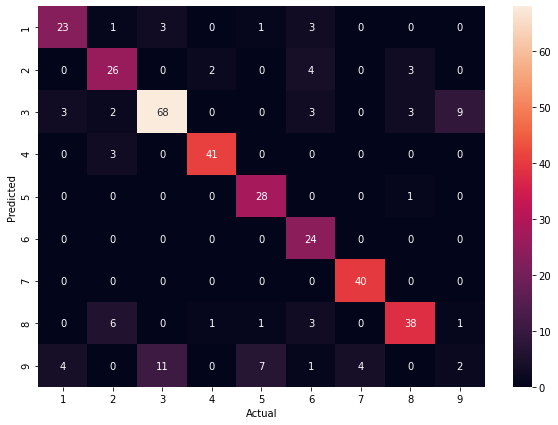

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix
conf_mat=confusion_matrix(labels_list.numpy(), pred_list.numpy())

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

df_cm = pd.DataFrame(conf_mat, index = [i for i in list(range(1,10))],
                  columns = [i for i in list(range(1,10))])

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True)
ax.set(xlabel='Actual', ylabel='Predicted')